# Tutorial

We use experimental data from the paper of [Lei](https://doi.org/10.1016/j.jallcom.2014.09.169) for LFP system.

First of all, we import the libraries that we will use throughout this example

In [1]:
import galpynostatic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data visualization

We define a [numpy](https://numpy.org/) array with the C-rates that were used to perform the measurements in the experiment.

In [2]:
C_rates = np.array([0.2, 0.5, 1, 2, 5, 10])

For each one of these C-rates we have a galvanostatic profile as a csv file, we read them with [pandas](https://pandas.pydata.org/) and store them in a list for further preprocessing

In [3]:
gprofiles = [pd.read_csv(f"_static/{c_rate}C.csv") for c_rate in C_rates]
gprofiles[0].keys()

Index(['capacity', 'voltage'], dtype='object')

we have a pd.DataFrame for each curve with a capacity and a voltage column. We also define from their work the equilibrium potential ($E^0$) and our cut-off potential ($E_{off}$)

In [4]:
eq_pot, vcut = 3.45, 0.15

We plot the curves to visualize them in the region $E^0 \pm E_{off}$

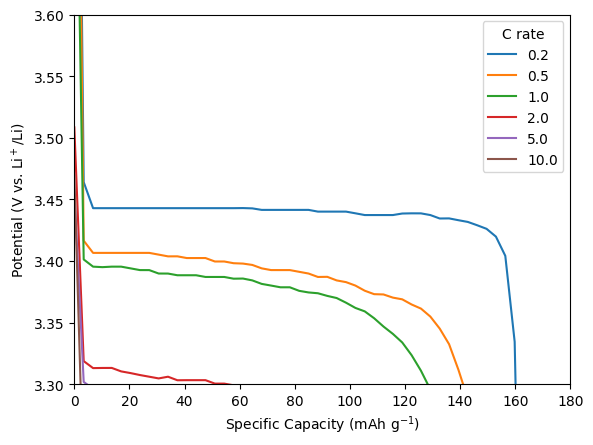

In [5]:
fig, ax = plt.subplots()

for c_rate, df in zip(C_rates, gprofiles):
    ax.plot(df.capacity, df.voltage, label=f"{c_rate}")
    
ax.set_xlim((0, 180))
ax.set_ylim((eq_pot - vcut, eq_pot + vcut))
ax.set_xlabel(r"Specific Capacity (mAh g$^{-1}$)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

## Preprocessing

In the physics-based heuristic model presented here, we are not interested in the entire profile behavior, instead we focus our analysis on the points where each curve intersects at a cut-off potential below the equilibrium potential. To obtain these values we can use the `galpynostatic.preprocessing` module.

In [6]:
gdc = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot, vcut=vcut)
dc = gdc.fit_transform(gprofiles)
dc

array([160.27911  , 141.21538  , 128.30042  ,  55.622726 ,   3.5315654,
         1.6230893], dtype=float32)

We must normalize these currents by a maximum value that we define (here we use the maximum value of the capacity for the lowest C-rate reported in the paper as $168.9 mAh g^{-1}$) to obtain the SOC between 0 and 1, which is going to be the dependent variable of our model.

In [7]:
soc = dc / 168.9

## Fitting

First, we display the data in the way that is going to be used by the model

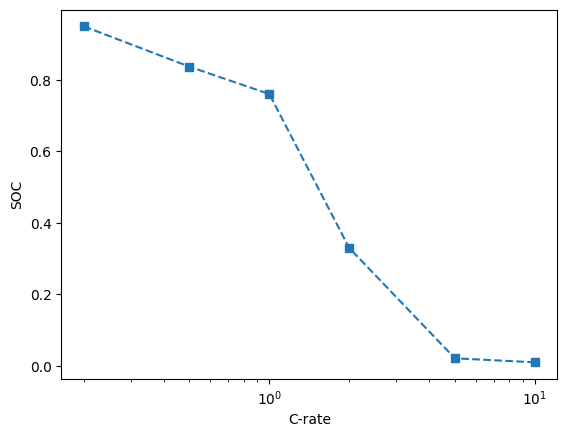

In [8]:
fig, ax = plt.subplots()

plt.plot(C_rates, soc, marker="s", ls="--")

plt.xlabel("C-rate")
plt.ylabel("SOC")
plt.xscale("log")
plt.show()

and reshape the X values as in the usual way that is used by [scikit-learn](https://scikit-learn.org/stable/) convention

In [9]:
C_rates = C_rates.reshape(-1, 1)

In the paper it is mentioned that the particle sizes are distributed between $200-500 nm$, we take the mid point and give it in $cm$ which is the required unit

In [10]:
d = 3.5e-5

We load the surface data for spherical geometry with a $150 mV$ cut-off potential and define the $z$-value which is a number that depends on the geometry, here is 3

In [11]:
dataset = galpynostatic.datasets.load_spherical()
z = 3

Now we have all the information needed to fit the model

In [12]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, z)
greg.fit(C_rates, soc)

We have two types of plots available, one of them to visualize the region of the diagram where the experimental data is located after the fitting

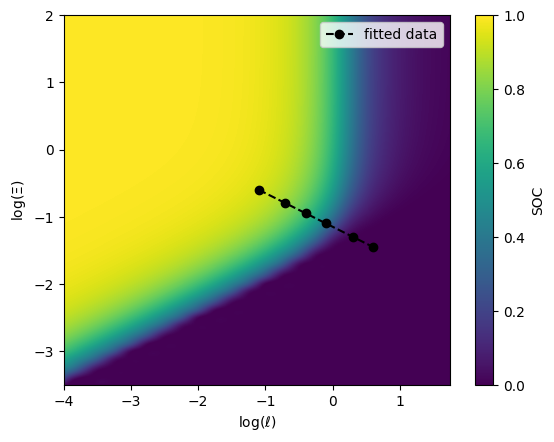

In [13]:
greg.plot.in_surface(C_rates)
plt.legend()
plt.show()

and the one to visualize the predicted values against the experimental ones in the same format as they were used for the fitting

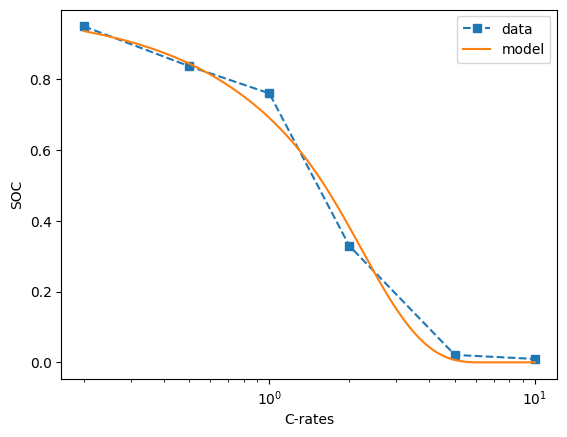

In [14]:
greg.plot.versus_data(C_rates, soc)
plt.legend()
plt.show()

## Predictions

We can get fundamental parameters of the system by accessing to attributes of the `GalvanostaticRegressor` model, such as the diffusion coefficient (in $cm^2/s$)

In [15]:
greg.dcoeff_

2.848035868435805e-13

which are in high agreement with the three values obtained in their work of 1.04e-12, 1.74e-13 and 8.22e-13, which comes from the slope of a straight line in EIS measurements.

On the other side we can also obtain the kinetic rate constant (in $cm/s$)

In [16]:
greg.k0_

1e-09

that is also in high agreement with the experimental one of 1.23e-9, calculated using the [Butler-Volmer equation](https://en.wikipedia.org/wiki/Butler%E2%80%93Volmer_equation) with the reported $i^0$ value.

Finally, there is a standard for fast-charging, proposed by the United States Advanced Battery Consortium (USABC), that aims the extremely fast-charging of 80% of the State-of-Charge (SOC) in 15 minutes. This translates to a SOC value of 0.8 and a C-rate of 4C. A prediction on the particle size needed to satisfy this criterion can be quickly done with the `predict_length` function in `galpynostatic.size` module (which have the default values of the criterion defined)

In [17]:
d_new = galpynostatic.size.predict_length(greg, cm_to=1)
d_new

8.36253773855037e-06

This value is in $cm$ and can be compared with the original one ($d$)

In [18]:
d

3.5e-05

where it is clear that the system must be improved by reducing the particle size in approximately one order of magnitude.